In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
z500_anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/DailyDetrendedStdAnoms_v3/Z500_ERA5_Region.nc')

dataset_raw = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/DailyDatasets/Z500_ERA5.nc')
dataset_raw = dataset_raw.sel(time=pd.to_datetime(dataset_raw.time)<'2021-01-01')

In [3]:
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

z500_anoms_region = z500_anoms.where((z500_anoms.lat>=lat0)&(z500_anoms.lat<=lat1)&\
                   (z500_anoms.lon>=lon0)&(z500_anoms.lon<=lon1),drop=True)
z500_anoms_region = z500_anoms_region.sel(time=pd.to_datetime(z500_anoms_region.time)<'2021-01-01')

In [4]:
var_name = 'Z_anomalies'

In [5]:
z500_anoms_flattened = z500_anoms_region.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
# z500_anoms_flattened = z500_anoms_flattened.data

# PCA

In [7]:
z500_anoms_flattened_training = z500_anoms_flattened

In [8]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened_training)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened_training)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [18.65906988 14.5549344   9.83618974  7.34153717  6.40732164  5.8827646
  5.12929864  4.5507537   3.41138423  2.93692114  2.56260771  2.20984011]
Cumulative sum of variance explained for EOF1 and EOF2: [18.65906988 33.21400427 43.05019401 50.39173118 56.79905282 62.68181743
 67.81111606 72.36186976 75.77325399 78.71017514 81.27278284 83.48262295]


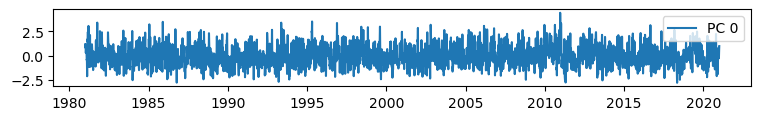

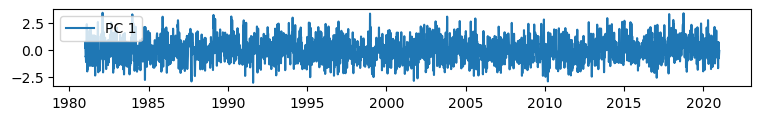

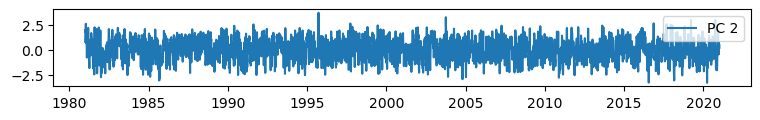

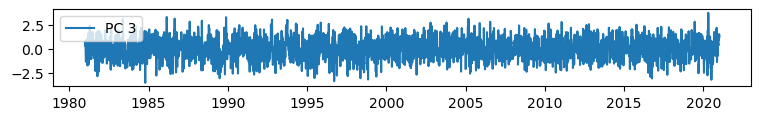

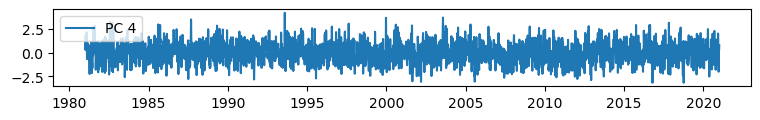

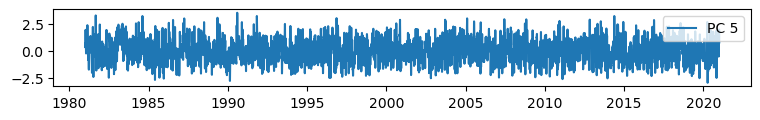

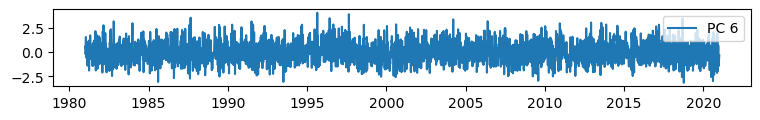

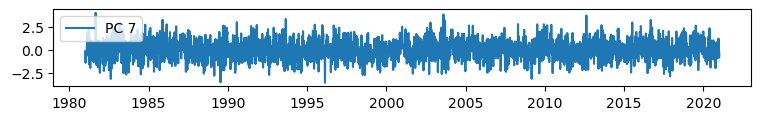

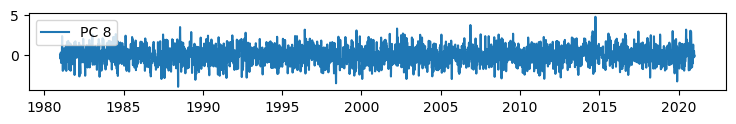

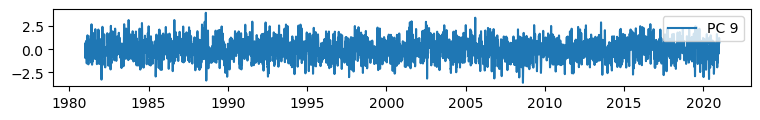

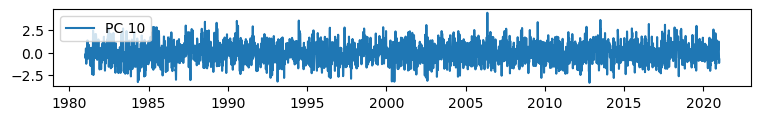

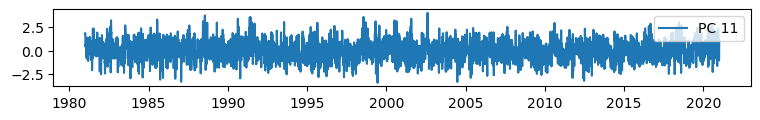

In [9]:
for i in range(12):
    plt.figure(figsize=(9,1))
    plt.plot(z500_anoms_region.time,z500_anoms_transformed[:,i],
             label=f'PC {i}')
    plt.legend()
    plt.show()
    plt.close()

# k-means

In [11]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 # init='k-means++',
                 n_init=500,
                 max_iter=500,
                 # tol=0.0001,
                 verbose=0,
                 random_state=0).fit(z500_anoms_transformed)

print(f'inertia: {k_means.inertia_}')

inertia: 151999.9793180763


In [13]:
import joblib

filename = r'/glade/work/jhayron/Data4Predictability/PCA_ERA5_v20241226.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/work/jhayron/Data4Predictability/KMeans_ERA5_v20241226.mdl'
joblib.dump(k_means,filename)

['/glade/work/jhayron/Data4Predictability/KMeans_ERA5_v20241226.mdl']

In [14]:
filename = r'/glade/work/jhayron/Data4Predictability/PCA_ERA5_v20241226.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

filename = r'/glade/work/jhayron/Data4Predictability/KMeans_ERA5_v20241226.pkl'
pickle.dump(k_means, open(filename, 'wb'))

In [15]:
initial_cluster_centers = k_means.cluster_centers_

In [16]:
new_cluster_centers = np.vstack([initial_cluster_centers,np.zeros(12)]) #Added a new center at 0,0,...,0 for unknown WR

## load models

In [6]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Data4Predictability/PCA_ERA5_v20241226.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Data4Predictability/KMeans_ERA5_v20241226.mdl')
# data_era5_train = pca_obj.transform(data_era5_train)

In [7]:
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

In [8]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

In [9]:
initial_cluster_centers = k_means.cluster_centers_
new_cluster_centers = np.vstack([initial_cluster_centers,np.zeros(12)]) #Added a new center at 0,0,...,0 for unknown WR

In [10]:
#sort by frequency
new_cluster_centers = new_cluster_centers[[1,3,0,2,4]]

In [11]:
# weather_patterns = k_means.predict(z500_anoms_transformed)
euc_res=euclidean_distances(new_cluster_centers, z500_anoms_transformed)
weather_patterns = euc_res.argmin(axis=0)
dist = euc_res.min(axis=0)
df_test = pd.DataFrame(weather_patterns,index=pd.to_datetime(anomalies_afterPCA.time),columns=['wr'])
df_test['dist'] = dist
df_test.loc[df_test.dist>=np.percentile(df_test.dist,90),'wr'] = 4 ### Classify as No-WR the 10% that are more distant from centroid

In [12]:
where0 = np.where(df_test['wr']==0)
where1 = np.where(df_test['wr']==1)
where2 = np.where(df_test['wr']==2)
where3 = np.where(df_test['wr']==3)
where4 = np.where(df_test['wr']==4)

print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

print('Pattern #4:')
print(np.round(100*len(where4[0])/len(weather_patterns),2))

p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)
p4 = np.round(len(where4[0])/len(weather_patterns),2)

Pattern #0:
24.92
Pattern #1:
21.9
Pattern #2:
17.4
Pattern #3:
13.66
Pattern #4:
22.11


In [13]:
mean_wr_0 = z500_anoms.Z_anomalies[where0].mean(axis=0)#/9.82
mean_wr_1 = z500_anoms.Z_anomalies[where1].mean(axis=0)#/9.82
mean_wr_2 = z500_anoms.Z_anomalies[where2].mean(axis=0)#/9.82
mean_wr_3 = z500_anoms.Z_anomalies[where3].mean(axis=0)#/9.82
mean_wr_4 = z500_anoms.Z_anomalies[where4].mean(axis=0)#/9.82

composites = [mean_wr_0.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_1.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_2.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_3.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_4.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon)
             ]

In [14]:
### Everything depends on this dataframe... be careful
# df_test.to_csv('/glade/work/jhayron/Data4Predictability/WR_Series_v20241226.csv')

In [15]:
# Add a cyclic point to avoid the white line at the map boundaries
from cartopy.util import add_cyclic_point

# Assuming `mean_wr_0` is your DataArray and has the 'lon' coordinate
cyclic_data, cyclic_lons = add_cyclic_point(mean_wr_0, coord=mean_wr_0['lon'], axis=-1)

# Create a new DataArray with the cyclic longitudes
mean_wr_0_cyclic = xr.DataArray(
    cyclic_data,
    dims=["lat", "lon"],
    coords={"lat": mean_wr_0["lat"], "lon": cyclic_lons},
    attrs=mean_wr_0.attrs
)

# Assuming `mean_wr_0` is your DataArray and has the 'lon' coordinate
cyclic_data, cyclic_lons = add_cyclic_point(mean_wr_1, coord=mean_wr_1['lon'], axis=-1)

# Create a new DataArray with the cyclic longitudes
mean_wr_1_cyclic = xr.DataArray(
    cyclic_data,
    dims=["lat", "lon"],
    coords={"lat": mean_wr_1["lat"], "lon": cyclic_lons},
    attrs=mean_wr_1.attrs
)

# Assuming `mean_wr_0` is your DataArray and has the 'lon' coordinate
cyclic_data, cyclic_lons = add_cyclic_point(mean_wr_2, coord=mean_wr_2['lon'], axis=-1)

# Create a new DataArray with the cyclic longitudes
mean_wr_2_cyclic = xr.DataArray(
    cyclic_data,
    dims=["lat", "lon"],
    coords={"lat": mean_wr_2["lat"], "lon": cyclic_lons},
    attrs=mean_wr_2.attrs
)

# Assuming `mean_wr_0` is your DataArray and has the 'lon' coordinate
cyclic_data, cyclic_lons = add_cyclic_point(mean_wr_3, coord=mean_wr_3['lon'], axis=-1)

# Create a new DataArray with the cyclic longitudes
mean_wr_3_cyclic = xr.DataArray(
    cyclic_data,
    dims=["lat", "lon"],
    coords={"lat": mean_wr_3["lat"], "lon": cyclic_lons},
    attrs=mean_wr_3.attrs
)

/glade/derecho/scratch/jhayron/tmp/ipykernel_234544/2133282082.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


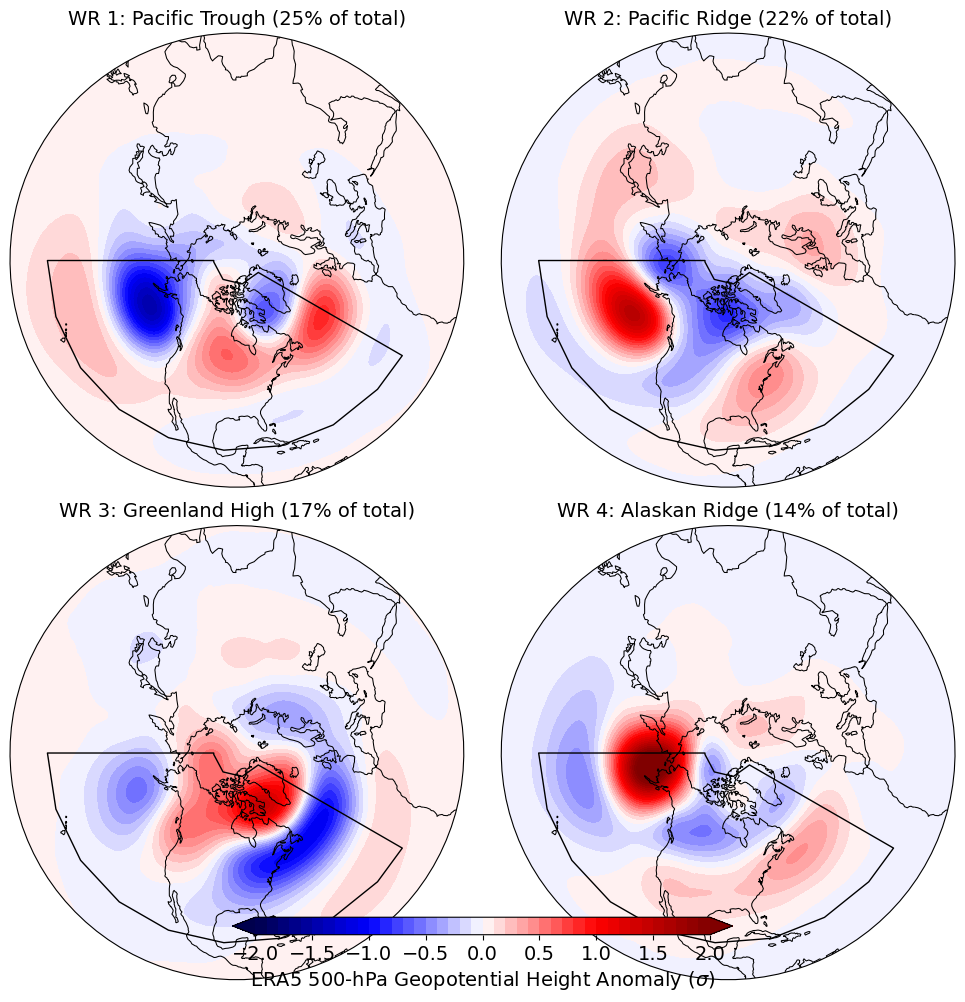

In [18]:
lons, lats = np.meshgrid(mean_wr_3_cyclic.lon, mean_wr_3_cyclic.lat)
names = ['Pacific Trough','Pacific Ridge','Greenland High','Alaskan Ridge']
arrays = [mean_wr_0_cyclic,mean_wr_1_cyclic,mean_wr_2_cyclic,mean_wr_3_cyclic]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---
mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].contourf(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(), levels=bounds,
                         vmin=mini, vmax=maxi, cmap='seismic',extend='both')

    axs[indax[0]][indax[1]].set_title(
        f'WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=lon0-360, maxx=lon1-360, miny=lat0, maxy=lat1)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=1.)
    
# ---

cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.0175])

ticks_1 = [-2,-1.5,-1, -0.5, 0, 0.5, 1,1.5,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly ($\sigma$)', fontsize=14)

# ---
plt.tight_layout()
plt.savefig("1_WR_Composites.png", bbox_inches='tight')
# plt.show()
# ---


# visualize examples

In [71]:
namesfull = ['Pacific Trough', 'Pacific Ridge', 'Greenland High', 'Alaskan Ridge','No WR']

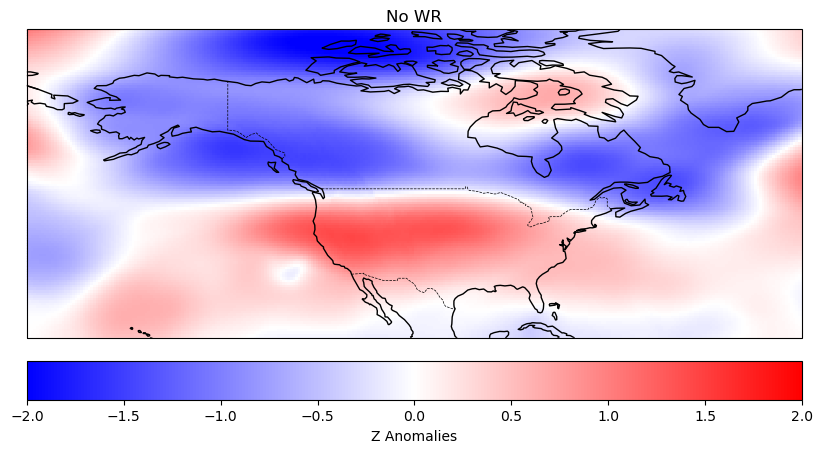

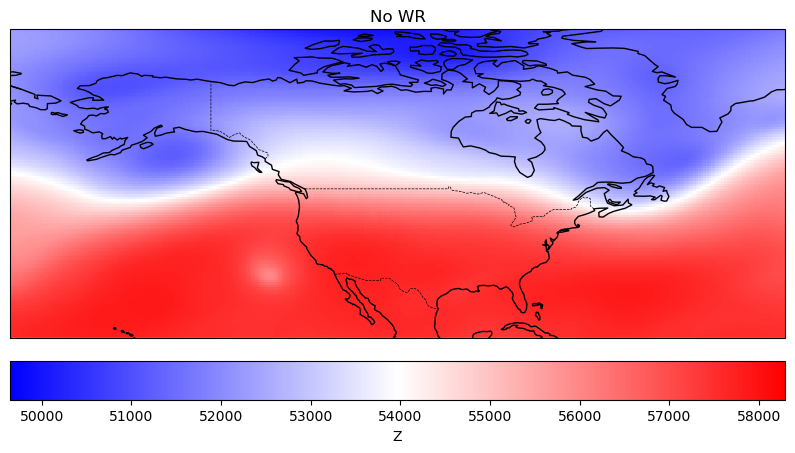

In [105]:
import random

# Generate a random integer between 10 and 20 (inclusive)
random_int = random.randint(0, len(df_test))

# Create a plot with a Cartopy projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the data
pcm = ax.pcolormesh(
    z500_anoms_region.lon,
    z500_anoms_region.lat,
    z500_anoms_region.sel(time=df_test.index[random_int]).Z_anomalies,
    vmin=-2,
    vmax=2,
    cmap="bwr",
    transform=ccrs.PlateCarree()  # Ensure data is plotted in PlateCarree projection
)

plt.title(f"{namesfull[int(df_test.iloc[random_int]['wr'])]}")
ax.set_extent([z500_anoms_region.lon.min(), z500_anoms_region.lon.max(), 
               z500_anoms_region.lat.min(), z500_anoms_region.lat.max()], crs=ccrs.PlateCarree())

# Add coastlines and continents
ax.coastlines(resolution="110m", color="black", linewidth=1)
# ax.add_feature(cfeature.LAND, facecolor="lightgray")  # Add continents
ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)

# Add a colorbar
cbar = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Z Anomalies")

# Show the plot
plt.show()
plt.close('all')

# Create a plot with a Cartopy projection
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the data
pcm = ax.pcolormesh(
    dataset_raw.lon,
    dataset_raw.lat,
    dataset_raw.sel(time=df_test.index[random_int]).Z,
    # vmin=-2,
    # vmax=2,
    cmap="bwr",
    transform=ccrs.PlateCarree()  # Ensure data is plotted in PlateCarree projection
)

plt.title(namesfull[int(df_test.iloc[random_int]['wr'])])
ax.set_extent([z500_anoms_region.lon.min(), z500_anoms_region.lon.max(), 
               z500_anoms_region.lat.min(), z500_anoms_region.lat.max()], crs=ccrs.PlateCarree())

# Add coastlines and continents
ax.coastlines(resolution="110m", color="black", linewidth=1)
# ax.add_feature(cfeature.LAND, facecolor="lightgray")  # Add continents
ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)

# Add a colorbar
cbar = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Z")

# Show the plot
plt.show()

In [21]:
# corrs = []
# for i in range(len(df_test)):
#     serieatemp = z500_anoms_region.sel(time=df_test.index[i]).Z_anomalies.values.ravel()
#     seriebtemp = composites[int(df_test.iloc[i]['wr'])].values.ravel()
#     corr_temp = np.corrcoef(serieatemp,seriebtemp)[0,1]
#     corrs.append(corr_temp)
# df_test['corr'] = corrs

In [22]:
# plt.hist(corrs)

In [23]:
# df_test.loc[df_test['corr']<=0.4,'wr'] = 4